## 4章 章末問題

In [1]:
import pandas as pd
import statsmodels.api as sm

---
#### (1) 4.9節ではマーケットリスクプレミアムが月間 0.3%と仮定して，各銘柄の期待リターンを推定し，理論株価を評価した。最近のサーベイ調査によるとマーケットリスクプレミアムは月間 0.51%であるという。マーケットリスクプレミアムを月間 0.51%として，改めてV/Pが1を上回る割安株で構成されたポートフォリオを構築し，向こう 1 年間において等加重で運用した場合と時価総額加重で運用した場合のリターンを比較してみよう。

---

In [15]:
# 以下、コード4.1〜4.4を再掲し、コード4.3のリスクプレミアム0.3%を0.51%に変更している(87行目)。
# 途中経過を表示するprint()はコメントアウトしている。
# ただし、(3)の問題に備え、V/P>1の銘柄数を表示する94行目はコメントアウトしていない。

####
# コード 4.1 ライブラリの読み込みと入力データの準備

# 各銘柄のβ推定などに利用するffMonthly.csvを読み込み
ffMonthly = pd.read_csv('./data/ffMonthly.csv', parse_dates=['month'])
ffMonthly['month'] = ffMonthly['month'].dt.to_period('M')
# print(ffMonthly)
##        month   RMRF   SMB   HML    RF
## 0    1990-07  20.67 -1.56 -5.16  0.68
## 1    1990-08 -13.69 -3.63  0.98  0.66

# 必要なデータの選択(行と列の選択)
# 産業A(tickerがAから始まる) の月次リターンデータを読み込み
stockMonthly = pd.read_csv('./data/stockMonthly.csv', parse_dates=['month'])
stockMonthly['month'] = stockMonthly['month'].dt.to_period('M')
stockMonthly = stockMonthly[stockMonthly['industry'] == 'A']

# β推定のために，2008/7-2013/6の60ヶ月のデータを選択
df = stockMonthly[(stockMonthly['month'] >= '2008-7') &
                  (stockMonthly['month'] <= '2013-6')].copy()
df = df[['ticker', 'month', 'close', 'return', 'share']]
# ffMonthlyを結合し各銘柄の月次超過リターン (RIRF)を求める
df = pd.merge(df, ffMonthly[['month', 'RMRF', 'RF']], on='month')
df['RIRF'] = df['return'] - df['RF']
# print(df)
##      ticker    month  close     return      share   RMRF    RF       RIRF
## 0     A0001  2008-07   2820  -7.571288   15815814   3.24  0.15  -7.721288
## 1     A0002  2008-07  12484  16.270840    5046567   3.24  0.15  16.120840

# V/P推定後の運用期間データの選択
futureRet = stockMonthly[(stockMonthly['month'] >= '2013-7') &
                         (stockMonthly['month'] <= '2014-6')]
futureRet = futureRet[['ticker', 'month', 'return']]
# print(futureRet)
##       ticker    month     return
## 270    A0001  2013-07  22.149300
## 271    A0001  2013-08   8.260577

# 各銘柄の1期先の予想配当データの読み込み
fy1D = pd.read_csv('./data/dividendData.csv')
# print(fy1D)
##    ticker  fy1Dividend
## 0   A0001         52.0
## 1   A0002        148.0

######
# コード 4.2 ticker別にベータを推定する
# 単回帰でβを推定する関数
def calBeta(d):
    model = sm.OLS(d['RIRF'], sm.add_constant(d['RMRF']))  # 単回帰モデル
    res = model.fit()  # OLSによる回帰係数の推定
    return res.params['RMRF']  # 推定された定数項とRMRFの回帰係数


# print(df[['ticker', 'RIRF', 'RMRF']])
##      ticker       RIRF   RMRF
## 0     A0001  -7.721288   3.24
## 1     A0002  16.120840   3.24

# 銘柄ごとにβを推定
beta = df[['ticker', 'RIRF', 'RMRF']].groupby('ticker').apply(calBeta)
beta.name = 'beta'
# print(beta)
## ticker
## A0001    1.087651
## A0002    0.235348
##           ...
## A0079    0.449321
## A0080    0.826608
## Name: beta, Length: 77, dtype: float64


####
# コード 4.3 2013年6月の株価データから割安株を選択するプログラム

# ポートフォリを組成する銘柄の選択と投資ウェイトの計算
# 各銘柄の2013年6月末時点のV/Pを計算するため，2013-06を選択，予想配当やβも結合
df2 = df[df['month'] == '2013-06'].copy()
df2 = pd.merge(df2, fy1D, on='ticker')
df2 = pd.merge(df2, beta, on='ticker')

# 各銘柄のV/Pの推定値 (hatVP)の計算
# 年間の期待リターン（企業にとっての株式の資本コスト）単位は(%)
# マーケットリスクプレミアムは月間 0.3%とする  ##### ここを0.51%に変更する
df2['expRet'] = (df2['RF'] + df2['beta'] * 0.51) * 12
# 毎期fy1Dividendの配当が永続すると仮定した理論株価
df2['hatV'] = df2['fy1Dividend'] / (df2['expRet'] / 100)
df2['hatVP'] = df2['hatV'] / df2['close']  # 2013年6月末時点で推定されたV/P

# hatVPが1を上回る割安株だけを抽出
df2 = df2[df2['hatVP'] > 1.0]
print('len(df2):', len(df2))  ## 43  => 0.51%に変更することで 7に減る

# 抽出された割安株で構成されたポートフォリオを等加重と時価総額加重で運用するための投資ウェイトを計算しておく
df2['ew'] = 1.0 / len(df2)  # 等加重で運用する場合の各銘柄に対する投資ウェイト
df2['me'] = df2['close'] * df2['share']  # 各銘柄の時価総額 (= 株価 × 発行済み株式数)
df2['vw'] = df2['me'] / df2['me'].sum()  # 時価総額加重で運用する場合の各銘柄に対する投資ウェイト
# print(df2)

####
# コード4.4 ポートフォリオの評価

# 割安株で構成されたポートフォリオの運用結果
# 運用期間のデータに等加重と時価総額加重の場合のそれぞれの投資ウェイトを結合し，等加重平均リターンと加重平均リターンをそれぞれ求める
# tickerをキーに結合
futureRet2 = pd.merge(futureRet, df2[['ticker', 'ew', 'vw']], on='ticker')

futureRet2['ewRet'] = futureRet2['return'] * futureRet2['ew']
futureRet2['vwRet'] = futureRet2['return'] * futureRet2['vw']
print(futureRet2)
##     ticker    month     return        ew        vw     ewRet     vwRet
## 0    A0001  2013-07  22.149300  0.023256  0.002755  0.515100  0.061026
## 1    A0001  2013-08   8.260577  0.023256  0.002755  0.192106  0.022759

# 上で計算されたewRetとvwRetを月ごとに足し合わせれば完成
rsl = futureRet2[['month', 'ewRet', 'vwRet']].groupby('month').sum()
print(rsl)
##              ewRet      vwRet
## month
## 2013-07  -2.828633   4.815620
## 2013-08   6.110663  11.472223

len(df2): 7
   ticker    month     return        ew        vw     ewRet     vwRet
0   A0006  2013-07   7.046687  0.142857  0.186544  1.006670  1.314516
1   A0006  2013-08   4.573669  0.142857  0.186544  0.653381  0.853190
2   A0006  2013-09   6.935333  0.142857  0.186544  0.990762  1.293744
3   A0006  2013-10  -6.996787  0.142857  0.186544 -0.999541 -1.305208
4   A0006  2013-11  -5.025915  0.142857  0.186544 -0.717988 -0.937554
..    ...      ...        ...       ...       ...       ...       ...
79  A0061  2014-02  -7.207207  0.142857  0.070482 -1.029601 -0.507979
80  A0061  2014-03  33.009710  0.142857  0.070482  4.715673  2.326593
81  A0061  2014-04  -4.866180  0.142857  0.070482 -0.695169 -0.342979
82  A0061  2014-05  57.033250  0.142857  0.070482  8.147607  4.019823
83  A0061  2014-06  12.540720  0.142857  0.070482  1.791531  0.883896

[84 rows x 7 columns]
             ewRet      vwRet
month                        
2013-07   6.061446   6.875801
2013-08   7.161464   9.208966
2013-

---
#### (2) 問題(1)の等加重平均リターンの結果を利用し，マーケットポートフォリオリターン(RM)をベンチマークとする超過リターンを計算し，2013年6月を超過リターンゼロとして始め，2013年6月から2014年6月までの各月の累積超過リターンを描画してみよう。横軸は年月であり，縦軸は各月の累積超過リターンの図を出力するのが目標である。

---

<AxesSubplot:xlabel='month'>

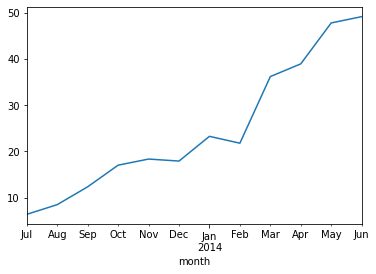

In [14]:
# ffMonthlyからRMRFとRFをmergeし，RM=RMRF+RFを計算する。
df2 = rsl.merge(ffMonthly[['month', 'RMRF', 'RF']], on='month')
df2['RM'] = df2['RMRF'] + df2['RF']

# 超過収益率を計算し，monthをindexに設定した後、累積超過収益率をplot()する。
df2['return'] = df2['ewRet'] - df2['RM']
df2 = df2.set_index('month')
df2['return'].cumsum().plot()

#### (3)問題(1)で抽出された銘柄数は，マーケットリスクプレミアムを0.3%にした場合と比較して，増えたのか減ったのかを検討し，その理由を考えてみよう。

(1)のスクリプトの94行目の結果より、マーケットリスクプレミアムが0.3%の場合は43銘柄選ばれたが、0.51%に変更すると 7銘柄に減少している。